### 3F4 Lab on Convolutional Coding and Decoding

Welcome to the new 3F4 lab on convolutional coding and decoding. In this lab we aim to learn the following:

1. Encoder:
  * Convert from octal notation
  * Encoding a binary data stream
2.  Graphs:
  * How to store graphs as data structures in Python
  * Build the state diagram graph of a convolutional code
  * Build a trellis graph for a convulutional code
3. Decoders:
  * Implement a Viterbi decoder
  * Implement a BCJR decoder
  * Simulate and investigate coding system performance
4. Looking further:
  * Turbo coding
  * Channels with insertions and deletions (with applications to DNA alignment)



## 1. Encoder

In order to convert between octal notation and binary, we first need a function to convert from a number in one base to a number in another base. Here, we consider "number" to be a list of numbers where the last number in the list is the least significant number. This should do the trick:


In [4]:
def base2number(x,b):
  # "numbers" are stored as lists, MSB first
  # compute the number x in base b
  number = 0
  q = 1
  for k in reversed(x):
    number += k * q
    q *= b
  return(number)

def number2base(x,b,length=None):
  y = []
  while x:
    y.append(int(x%b))
    x //= b
  if length != None:
    y.extend([0]*(length-len(y)))
  return(y[::-1]) # reverse output vector to MSB -> LSB

def base2base(x,b1,b2):
  number = base2number(x,b1)
  return(number2base(number, b2))

Now let's try this out to convert a convolutional code described in octal notation to binary "polynomial" vectors. For example, take the $(15,17)_8$ convolutional code:

In [5]:
p1 = base2base([1,5],8,2)
p2 = base2base([1,7],8,2)
print(p1)
print(p2)
print(number2base(5,2))
print(number2base(5,2,5))

[1, 1, 0, 1]
[1, 1, 1, 1]
[1, 0, 1]
[0, 0, 1, 0, 1]


In [11]:
print(number2base(12345678, 8))
print(base2base([7, 6, 5, 4, 3], 8, 2))
print(base2number([1, 2, 3, 4, 5, 6], 54))
print(number2base(12345678, 9))
print(base2base([6, 5, 4, 3, 2, 1], 7, 2))
print(base2number([1, 2, 3, 4, 5, 6], 8))

[5, 7, 0, 6, 0, 5, 1, 6]
[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]
476655468
[2, 5, 2, 0, 6, 0, 7, 0]
[1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
42798


Now we need an encoder that takes a convolutional code description in octal and generates a stream of output data for a given stream of output data. This should do the trick:

In [ ]:
def conv_encode_symbol(input_symbol, binary_polynomials, state=None):
  if state==None:
    state = [0]*(max([len(p) for p in binary_polynomials])-1)
  state.insert(0,input_symbol)
  output = []
  for k in range(len(binary_polynomials)):
    output.append(int(sum(x*y for x,y in zip(state,binary_polynomials[k]))%2))
  state.pop()
  return output, state

def conv_encode_list(input_list, octal_polynomials, terminated = True):
  binary_polynomials = []
  for p in octal_polynomials:
    binary_polynomials.append(base2base(p,8,2))
  output, state = conv_encode_symbol(input_list[0],binary_polynomials)
  for input_symbol in input_list[1:]:
    new_output,state = conv_encode_symbol(input_symbol,binary_polynomials,state)
    output.extend(new_output)
  if (terminated == True):
    for n in range(len(state)):
      new_output,state = conv_encode_symbol(0,binary_polynomials,state)
      output.extend(new_output)
  return(output)

Let's test this for a n input symbol and for a short input list:

In [17]:
[out,state] = conv_encode_symbol(1,[[1,0,1],[1,1,1]],[1,1])
print(out)
print(state)

out = conv_encode_list([0,1,0,1,1],[[5],[7]])
print(out)

[0, 1]
[1, 1]
[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]


Try this for a few other input lists...

In [36]:
input_lists = [[1, 0, 1, 0, 0, 1], [1, 1, 1, 1, 1, 1]]
oct_list = [[[25], [37]], [[55], [57]]]

for i in range(2):
    for k in range(2):
        encoded_output = conv_encode_list(input_lists[i], oct_list[k], terminated=True)
        print(encoded_output)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]
[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]


## 2. Graphs

We now explore data structures that can store graphs in Python and use this to store a convolutional code's state diagram and trellis.

A basic graph in python can be stored as a dictionary of nodes where each node stores a list of nodes it is connected to. For a directed graph (the only sort of graph we ware interested in in our context) we can separate this into a list of forward and backward nodes.

Here is an example of a class that would implement such a graph, and an example of a small graph:

In [40]:
# class graph_node:
#   def __init__(self, name="", forward_nodes=[], backward_nodes=[]):
#     self.name = name
#     self.forward_nodes = forward_nodes
#     self.backward_nodes = backward_nodes
#   def __str__(self):
#     return f"Name: {self.name}, Forward nodes: {self.forward_nodes}, Backward nodes: {self.backward_nodes}"

class GraphNode:
    def __init__(self, name="", forward_nodes=None, backward_nodes=None):
        self.name = name
        self.forward_nodes = forward_nodes if forward_nodes is not None else []
        self.backward_nodes = backward_nodes if backward_nodes is not None else []

    def __str__(self):
        forward_names = [node.name for node in self.forward_nodes]
        backward_names = [node.name for node in self.backward_nodes]
        return f"Name: {self.name}, Forward nodes: {forward_names}, Backward nodes: {backward_names}"

    def add_forward_node(self, node):
        """Add a forward node."""
        if node not in self.forward_nodes:
            self.forward_nodes.append(node)
            node.add_backward_node(self)

    def add_backward_node(self, node):
        """Add a backward node."""
        if node not in self.backward_nodes:
            self.backward_nodes.append(node)
            node.add_forward_node(self)

    def remove_forward_node(self, node):
        """Remove a forward node."""
        if node in self.forward_nodes:
            self.forward_nodes.remove(node)
            node.remove_backward_node(self)

    def remove_backward_node(self, node):
        """Remove a backward node."""
        if node in self.backward_nodes:
            self.backward_nodes.remove(node)
            node.remove_forward_node(self)

    def get_forward_nodes(self):
        """Return a list of forward nodes."""
        return self.forward_nodes

    def get_backward_nodes(self):
        """Return a list of backward nodes."""
        return self.backward_nodes

n1=graph_node(0,[1,2],[3])
n2=graph_node(1,3,0)
n3=graph_node(2,3,0)
n4=graph_node(3,0,[1,2])

print(n1)
print(n2)
print(n3)
print(n4)

Name: 0, Forward nodes: [1, 2], Backward nodes: [3]
Name: 1, Forward nodes: 3, Backward nodes: 0
Name: 2, Forward nodes: 3, Backward nodes: 0
Name: 3, Forward nodes: 0, Backward nodes: [1, 2]


However, the representation of a graph at this level is rather clonky. While establishing a data structure to store and work with graphs is simple in Python, drawing a graph is a different matter and requires some advanced programming skills. Hence, if we want to visualise our graphs we are better off importing a library that does it for us. There are several graphing libraries available in Python and we explored two in particular:
*  igraph
*  NetworkX

I decided to use the first of the two (mainly because I liked that its name is in lower case).

Here is the graph above stored and drawn using igraph:


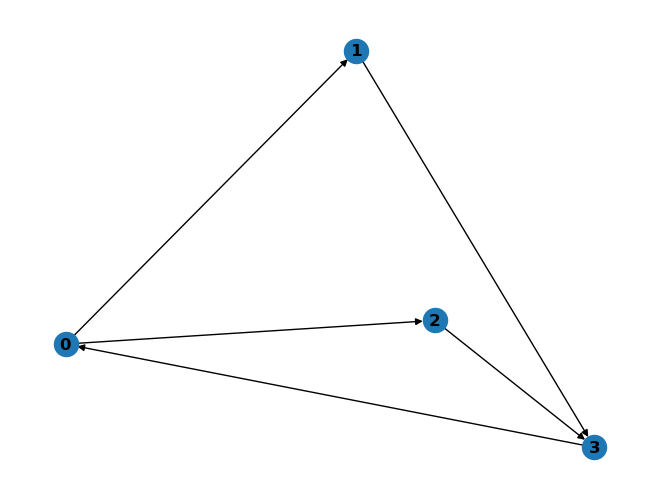

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
dummy_graph = nx.DiGraph([(0,1),(0,2),(1,3),(2,3),(3,0)])
nx.draw(dummy_graph, with_labels=True, font_weight='bold')

We can now build a function that draws the state diagram of a convolutional code as an igraph. Let us start with the $(5,7)_8$ code that we know from the lectures.

In [43]:
def conv_state_diagram(octal_polynomials):
  binary_polynomials = []
  for p in octal_polynomials:
    binary_polynomials.append(base2base(p,8,2))
  output, state = conv_encode_symbol(0, binary_polynomials)
  L = len(state)
  n_nodes = 2**L
  g = nx.DiGraph()
  g.add_nodes_from(range(n_nodes))
  for in_node in range(n_nodes):
    state=number2base(in_node,2,L)
    g.nodes[in_node]["state"] = ''.join(str(n) for n in state)
    for input_symbol in [0,1]:
      state=number2base(in_node,2,L)
      output,state = conv_encode_symbol(input_symbol,binary_polynomials,state)
      out_node = base2number(state,2)
      g.add_edge(in_node,out_node,in_out=f"{str(input_symbol)}/{''.join(str(n) for n in output)}")
  return(g)

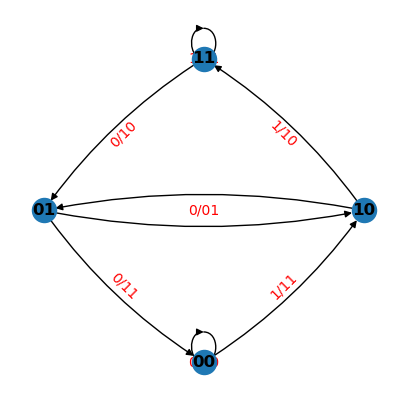

In [45]:
sd = conv_state_diagram([[5],[7]])
layout = [(0,0),(-1,1),(1,1),(0,2)]
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
elabels={edge: sd.edges[edge]["in_out"] for edge in sd.edges()}
nx.draw_networkx_edge_labels(sd,layout,edge_labels=elabels,font_color='red')
nlabels={node: sd.nodes[node]["state"] for node in sd.nodes()}
nx.draw(sd, layout, labels=nlabels, with_labels=True, font_weight='bold',connectionstyle='arc3, rad = 0.1')
# There is an issue with labeling of the edges between states 01 and 10 and the two self-loops in the picture that I was not able to solve. Anyone who can think of a way to solve this, please let me know!

Now to build a trellis from the state diagram. This is a bit harder than just copying the state diagram at every turn because it's essential to include the build-up for the root for the susequent decoding algorithms to work. Termination is not important and would be difficult to programme so we left it out. In fact, once we have a Viterbi algorithm up we will discover a simple way to remove the nodes that are never attained for a terminated trellis so we will come back to this.  

In [47]:
def sd2trellis(sd, n_stages):
  td = nx.DiGraph()
  td.add_node((0,0),state=sd.nodes[0]["state"],stage=0,index=0) # (stage,node_no)
  for stage in range(n_stages):
    stage_nodes = [n for n in td.nodes() if n[0] == stage]
    for node in stage_nodes:
      for neighbour in sd.neighbors(node[1]):
        if not td.has_node((stage+1,neighbour)):
          td.add_node((stage+1,neighbour), state=sd.nodes[neighbour]["state"],stage=stage+1,index=neighbour)
        td.add_edge(node,(stage+1,neighbour),in_out=sd.edges[node[1],neighbour]["in_out"])
  return(td)

Let's try this function out and draw the resulting trellis.

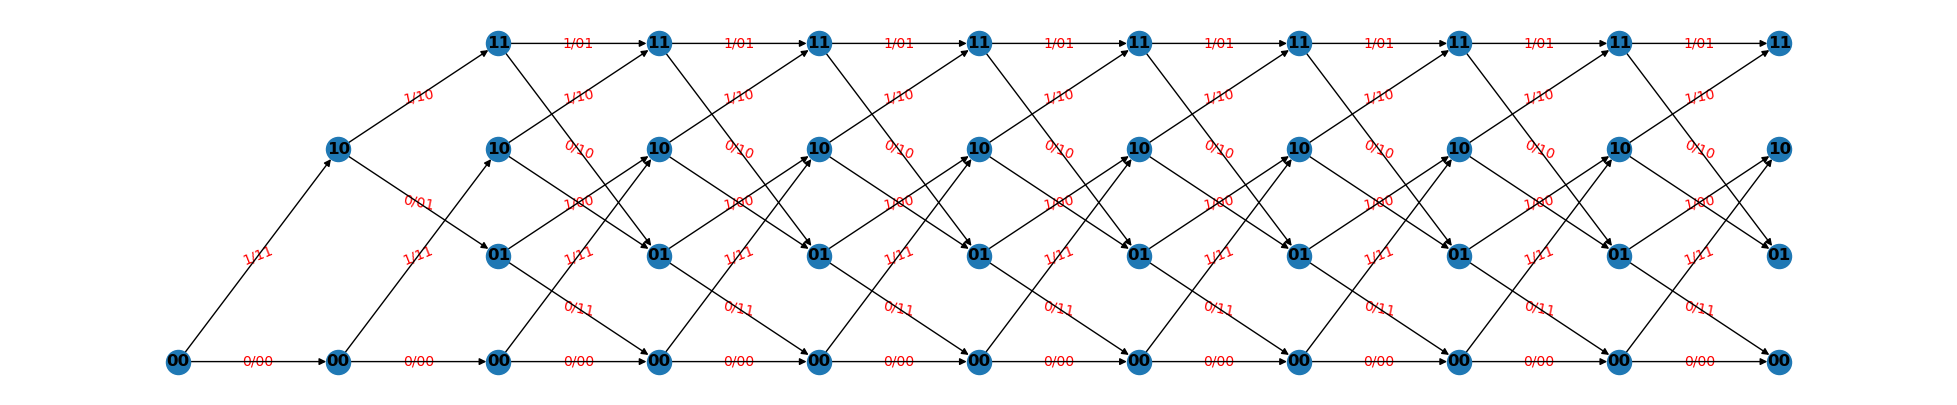

In [48]:
# we first define a function to draw a trellis as we may want to repeat this
# operation later in the lab when we study decoders
def draw_trellis(td, node_labels="state", edge_labels="in_out"):
  # we labeled our nodes in the trellis (stage,index) where index was their
  # label in the state diagram. Unfortunately, while networkX appears to support
  # nodes indexed as a tuple, its graphic rendering functions don't seem to
  # support it so we first need to convert the trellis to a graph whose nodes
  # are indexed as integers
  mapping = {n: idx for idx,n in enumerate(td.nodes)}
  g = nx.relabel_nodes(td,mapping)
  f = plt.figure()
  f.set_figwidth(25)
  f.set_figheight(5)
  # we now prepare a node layout where the x dimension is the trellis stage
  # and the y dimension is the node index in the state diagram
  layout = []
  for n in g.nodes:
    layout.append((g.nodes[n]["stage"],g.nodes[n]["index"]))
  # and now to draw the trellis
  elabels={edge: g.edges[edge][edge_labels] for edge in g.edges()}
  nx.draw_networkx_edge_labels(g,layout, edge_labels=elabels,font_color='red')
  nlabels={node: g.nodes[node][node_labels] for node in g.nodes()}
  nx.draw(g, layout, labels=nlabels, with_labels=True, font_weight='bold')

td=sd2trellis(sd,10)
draw_trellis(td)

## 3. Decoders

To look into trellis-based decoders, we first need to transmit some data over a noisy channel. We generate random data and encode it with a convolutional encoder, say $(15,17)_8$.

In [49]:
import random as rand

data_length = 12
# conv code polynomials
p1 = [1,5]
p2 = [1,7]
data = rand.getrandbits(data_length)
data = number2base(data,2,data_length)
codeword = conv_encode_list(data,[p1,p2])
# we rebuild the state diagram and trellis here to match the lengths (in case you fiddled with parameters in the first part of the lab)
sd = conv_state_diagram([p1,p2])
n_delays = len(sd.nodes[0]["state"])
td = sd2trellis(sd, data_length+n_delays)

We want to test decoders over a range of channel, say binary erasure channels (BEC), binary symmetric channels (BSC), and a Binary-input Additive White Gaussian Noise (BiAWGN) channel.

In [53]:
def Bernoulli(n,p):
  return([int(rand.random()<p) for n in range( n )])

def bec(x,p):
  n = len(x)
  e = Bernoulli(n,p)
  return([a if b == 0 else '?' for a,b in zip(x,e)])

def bsc(x,p):
  n = len(x)
  return([int((a+b)%2) for a,b in zip(x,Bernoulli(n,p))])

def awgn(x,sigma):
  return([a+rand.gauss(0,sigma) for a in x])


print(bec(codeword,.3))
print(bsc(codeword,.3))
print(awgn([1-x*2 for x in codeword],.5))

[1, 1, 0, 0, 0, 1, 1, 0, '?', 0, 0, 1, 1, '?', 0, 0, '?', 1, '?', 1, 0, 0, 0, 0, 1, 0, '?', 0, 1, 1]
[1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]
[-0.636408570365566, 0.18143729834806432, 0.9613019435800558, 0.7163490123989349, 1.3143529220881318, -1.3811418704032519, -0.8330508770692032, 0.43536411172361256, -0.7362095723561888, 0.8319117868438087, 0.47683006652193916, -1.2690875011480647, -0.5595656211457085, 0.9803906929982356, -0.29305102331557853, 0.3456509415620447, -0.4770758338635862, -0.761475749426818, 0.8721365438115697, -1.7226026707297475, 1.2521325880861378, 1.2060703084663942, 1.9438036117077353, 1.5045689734087904, -0.919350111219777, 1.6617353508217716, -0.9294088288205063, 1.5041767811173066, -0.8807443537874529, -1.2983524428216826]


We now build a Viterbi decoder. The Viterbi decoder best works in the logarithmic domain with an additive metric proportional to $-\log P(y|x)$, so that it turns into an algorithm that searches for the minimum metric path in order to achieve maximum likelihood. The algorithm has 3 phases:
* first we assign a metric $\gamma$ to every edge in the trellis
* then, we run the actual algorithm that computes metrics for the vertices by adding edge metrics to the metric of their originating vertex, and selecting the path of minimum metric when paths merge
* finally, we retrace our step backward to extract the minimum metric path.

We will consider a rooted and terminated trellis, since we returned our encoder to the zero state. This means that certain edges vertices in the trellis we drew earlier will never be visited by the decoder if they are not on a path from the root to the toor, but there is no harm in computing edge metrics for those edges in phase 1.

Note that I am capitalising Viterbi because I've met Andy Viterbi many times and although he is a fantastic engineer with much to his credit, and inventing this algorithm has certainly boosted his position in the history of telecommunications to a phenomenal dimension, I nevertheless don't feel completely comfortable in reducing his name to a lower-case object as if he were a household item like a hoover. If you haven't met Andy and prefer to think of "viterbi" as a quirky name for an algorithm rather than his surname, you are more than welcome to edit the function name below and remove the stylistic clash in python naming conventions. (Note that I also capitalised "Bernoulli" although I obviously never met him, but I do feel a special connection with him on account of our shared citizenship....)

In [63]:
def Viterbi(y, td, channel='bsc'):

  # phase 1: compute gammas
  N = len([int(a) for a in td.edges[((0,0),(1,0))]['in_out'][2:]]) # code rate 1/N
  for edge in td.edges:
    edge_output = [int(a) for a in td.edges[edge]['in_out'][2:]]
    y_pos = td.nodes[edge[0]]['stage']*N
    y_slice = y[y_pos:y_pos+N]
    if channel == 'bsc':
      td.edges[edge]['gamma'] = sum([int(a != b) for a,b in zip(edge_output, y_slice)])
    elif channel == 'bec':
      diff = [0 if (b=='?' or a == b) else 1 for a,b in zip(edge_output, y_slice)]
      if sum(diff) == 0:
        td.edges[edge]['gamma'] = 0
      else:
        td.edges[edge]['gamma'] = 1 # 1 is infinity for the BEC!
    elif channel == 'awgn':
      modulated_output = [1-2*a for a in edge_output]
      td.edges[edge]['gamma'] = sum([(a-b)**2 for a,b in zip(modulated_output, y_slice)])

  # phase 2: compute alphas
  # This phase can be implemented in a purely "forward" way if you are confident
  # of being able to visit your vertices in an order that will only ever visit
  # a vertex when all of its incoming edges are connected to vertices whose
  # alpha have already been computed. However, for more complicated trellises,
  # it may not be evident to design a forward path that visits all nodes in
  # order and hence there is a need for an approach that will work on every
  # trellis so we can use it in all applications of the Viterbi algorithm. The
  # approach implemented here is a bit was suggested to me by my 4th year
  # project student Omar Zaman: we start from the TOOR and operate a "stack" of
  # nodes that we are unable to compute. For the node at the top of the stack,
  # we check if its incoming neighbours have already been resolved. If yes, we
  # resolve the node and remove it from the stack. If not, we add the unresolved
  # incoming neighbours to the stack.
  for node in td.nodes:
    td.nodes[node]['alpha'] = -1 # initialise all vertices to -1
  root = (0,0)
  toor = (len(y)/N, 0)
  td.nodes[root]['alpha'] = 0 # initialise root vertex to 0
  vstack = [toor]
  while vstack:
    cnode = vstack[-1]
    incoming = [e for e in td.edges if e[1]==cnode]
    sources = [e[0] for e in incoming]
    source_alphas = [td.nodes[n]['alpha'] for n in sources]
    if any([x == -1 for x in source_alphas]):  # some origins are uncomputed
      for n in sources:
        if (td.nodes[n]["alpha"] == -1):
          vstack.append(n)
    else: # all origins computed, node can be resolved
      min_alpha = -1
      winner = -1
      for e in incoming:
        td.edges[e]['winning'] = 'loser' # preset all incoming to losing
        candidate_alpha = td.edges[e]['gamma'] + td.nodes[e[0]]['alpha']
        if min_alpha == -1 or candidate_alpha < min_alpha:
          winner = e
          min_alpha = candidate_alpha
      td.nodes[cnode]['alpha'] = min_alpha
      td.edges[winner]['winning'] = 'winner' # record the winning incoming
      vstack.pop() # delete vertex from stack

  # phase 3: backtrack to read out the winning path and metric
  cnode = toor;
  decoded = []
  while (td.nodes[cnode]["stage"] > 0):
    winner = [e for e in td.edges if e[1]==cnode and td.edges[e]['winning']=="winner"]
    winner = winner[0]
    decoded.append(int(td.edges[winner]['in_out'][0]))
    cnode = winner[0]
  decoded.reverse()
  min_metric = td.nodes[toor]['alpha']

  return decoded, min_metric

In [65]:
y = bsc(codeword, .1)
decoded,hamming_distance = Viterbi(y,td,'bsc')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'Hamming Distance: {hamming_distance}')

Codeword:         [1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Transmitted word: [1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]

Encoded data:                        [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]
Decoded word (with termination bits: [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]

Hamming Distance: 5


We can nicely visualise the operation of the Viterbi algorithm by labeling nodes with the $\alpha$ values and edges with their $\gamma$ values.

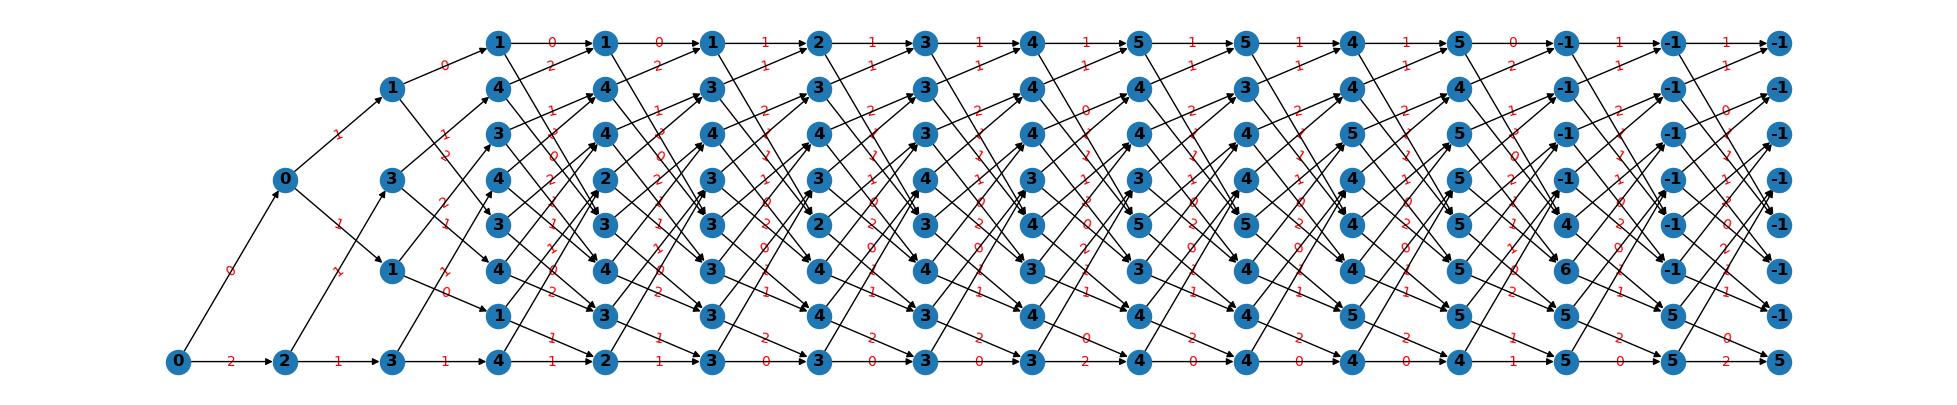

In [66]:
draw_trellis(td,"alpha","gamma")

Note now that the nodes not visited by the Viterbi algorithm have a label of -1. We can search for these nodes and amend our terminated trellis to include only relevant nodes (although the inclusion of the extra nodes did not interfere with the operation of the Viterbi algorithm and also won't interfere with the BCJR so this is optional.)

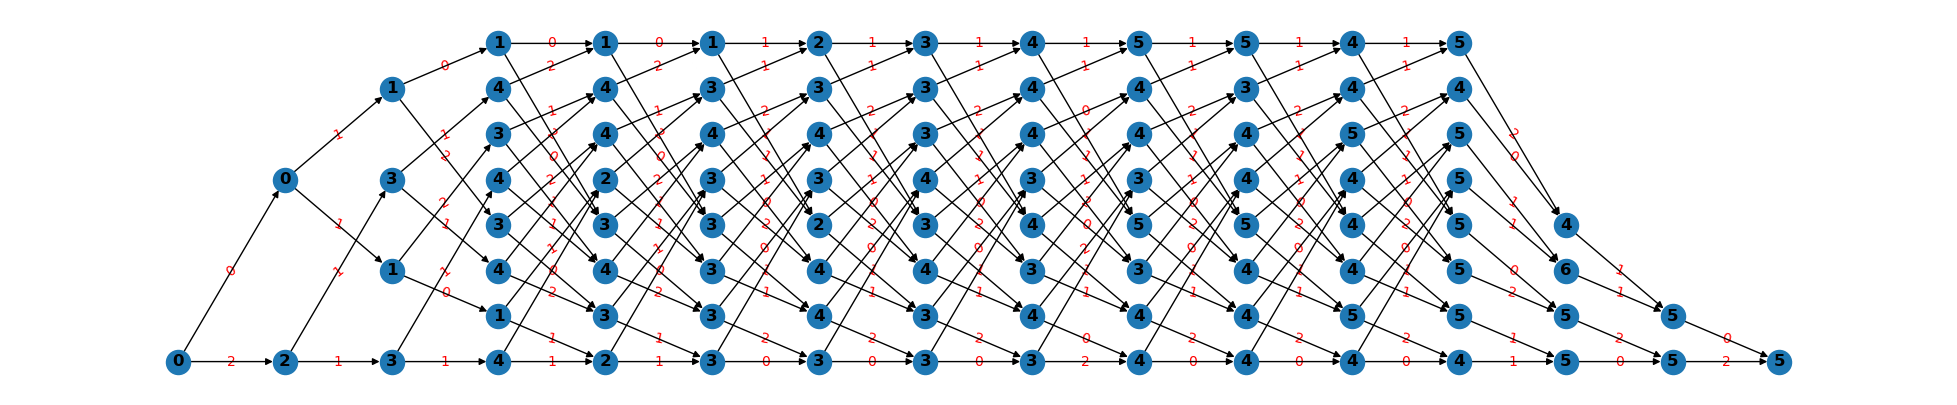

In [67]:
def clean_trellis_after_Viterbi(td):
  g = td
  useless_vertices = [n for n in g.nodes if td.nodes[n]["alpha"]==-1]
  for n in useless_vertices:
    g.remove_node(n)
  return g

g = clean_trellis_after_Viterbi(td)
draw_trellis(g,"alpha","gamma")

We can now try decoding for other channels.

In [68]:
y = bec(codeword, .2)
decoded, metric = Viterbi(y,td,'bec')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
if metric == 0:
  print('Decoding successful (but may not be correct)')
else:
  print('Illegal BEC behaviour!')

Codeword:         [1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Transmitted word: [1, 1, 0, 0, 0, '?', '?', 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, '?', 0, 0, 0, 0, 1, 0, '?', 0, '?', 1]

Encoded data:                        [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]
Decoded word (with termination bits: [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]

Decoding successful (but may not be correct)


In [69]:
y = awgn([1-x*2 for x in codeword],.8)
decoded, squared_distance = Viterbi(y,td,'awgn')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'Squared Euclidean Distance: {squared_distance}')

Codeword:         [1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Transmitted word: [-2.085462488535652, -1.7729499718437802, 0.6093369049313366, 0.8428148088095196, 1.779245783191319, -0.2503318436442621, -1.0282994823198168, 0.32961334345489046, -1.5130312443770917, 1.9436632105114229, 1.4242215391318853, -1.1899112371589684, 0.044246346874470266, 1.2818687416620693, 0.4691515414088834, 1.9579089737726252, -0.7321466854710956, -2.2237556509534606, 0.7688333089466153, -1.977924603534463, 0.48576100056908367, 2.097794601299594, -0.061384249304300864, 1.2709500625362742, -0.20071003586263636, 1.729504749701638, -0.13009416753630276, 1.2159779127673127, -2.588359467646254, -0.8788818166189848]

Encoded data:                        [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1]
Decoded word (with termination bits: [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]

Squared Euclidean Distance: 17.072095102175936


Now for the Bahl Cocke Jelinek Raviv (BCJR) algorithm implementation...  Unlike the Viterbi algorithm (that reduced to a minimisation of a metric that doesn't depend on the channel paramaters for the channels we considered), the BCJR will need to take those into account. Like the Viterbi, the BCJR has 3 phases:


1. Compute $\gamma$ for the edges depending the corresponding channel values, code digits and (new) channel parameter
2. Run the actual "forward backward" algorithm to compute the values $\alpha$ and $\beta$ for all the vertices
3. Summary phase where a-posteriori probabilites and/or decisions are taken for the individual symbol values

The 3rd phase of the BCJR algorithm is a lot richer in possibilities than the BCJR algorithm. The algorithm itself computes the a-posteriori probabity of each edge in the trellis given the observation vector. From that, one can compute a variety of metrics of interest such as the a-posteriori probability of each code digit, the a-posteriori probability of each data symbol, or other relevant summaries depending on the application. In this lab, we will limit ourselves to computing a-posteriori probabilities for the information symbols and taking optimal symbol-wise decisions about them.

We can try a first draft using just sums and products, bearing in mind that while this might work for small data blocklengths, it's likely to fail as the data length gets larger as the numbers involved in the sums become increasingly small. We will hence then need to develop a BCJR that operates in the logarithmic domain. In any case, we will use numpy in this implementation as the calculations are more sensitive.


In [80]:
import numpy as np

def draft_bcjr(y, td, channel='bsc', parameter=0.1):
  N = len([int(a) for a in td.edges[((0,0),(1,0))]['in_out'][2:]]) # code rate 1/N
  state_length = len(td.nodes[(0,0)]["state"])
  n_stages = int(len(y)/N)

  # phase 1: compute gammas
  for e in td.edges:
    edge_output = [int(a) for a in td.edges[e]["in_out"][2:]]
    y_pos = td.nodes[e[0]]["stage"]*N
    y_slice = y[y_pos:y_pos+N]
    if channel == 'bsc':
      hamming_distance = sum([int(a != b) for a,b in zip(edge_output, y_slice)])
      td.edges[e]["gamma"] = np.power(parameter, hamming_distance)*np.power(1-parameter,N-hamming_distance)
    elif channel == 'bec':
      count_erasures = sum([1 if a=='?' else 0 for a in y_slice])
      count_differences = sum([1 if (b != '?' and a != b) else 0 for a,b in zip(edge_output, y_slice)])
      if (count_differences > 0):
        td.edges[e]["gamma"] = 0
      else:
        td.edges[e]["gamma"] = np.power(parameter, count_erasures)*np.power(1-parameter, N-count_erasures)
    elif channel == 'awgn':
      modulated_output = np.array([1-2*a for a in edge_output])
      squared_distance = np.sum(np.power(y_slice - modulated_output,2))
      td.edges[e]["gamma"] = np.exp(-squared_distance/np.power(parameter,2.0))/np.sqrt(2.0*np.pi)/parameter

  # phase 2: run the forward backward algorithm
  for n in td.nodes:
    td.nodes[n]["alpha"] = 0 # initialise all vertices to 0
    td.nodes[n]["beta"] = 0 # initialise all vertices to 0
  root = (0,0)
  toor = (n_stages, 0)
  td.nodes[root]["alpha"] = 1 # initialise root alpha to 1
  td.nodes[toor]["beta"] = 1 # initialise toor beta to 1
  # forward
  for stage in range(1,n_stages+1):
    for n in [n for n in td.nodes if n[0]==stage]:
      for e in [e for e in td.edges if e[1] == n]:
        td.nodes[n]["alpha"] += td.edges[e]["gamma"]*td.nodes[e[0]]["alpha"]
  # backward
  for stage in range(n_stages-1,-1,-1):
    for n in [n for n in td.nodes if n[0]==stage]:
      for e in [e for e in td.edges if e[0]==n]:
        td.nodes[n]["beta"] += td.edges[e]["gamma"]*td.nodes[e[1]]["beta"]
  # now to multiply the alphas, betas and gammas
  for e in td.edges:
    td.edges[e]["gamma"] *= td.nodes[e[0]]["alpha"]*td.nodes[e[1]]["beta"]

  # Phase 3: summarise data symbol probabilities
  app = []
  decoded = []
  for stage in range(n_stages):
    sum0 = 0
    sum1 = 0
    for e in [e for e in td.edges if e[0][0]==stage]:
      if td.edges[e]["in_out"][0] == '0':
        sum0 += td.edges[e]["gamma"]
      else:
        sum1 += td.edges[e]["gamma"]
    with np.errstate(divide='ignore'):
      app.append(np.log(sum0/sum1))
    decoded.append(int(app[-1] < 0))

  return app, decoded


In [81]:
y = bsc(codeword, .1)
app, decoded = draft_bcjr(y,td,'bsc',.1)
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'A-posteriori log-likelihoods: {app}')



Codeword:         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Transmitted word: [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]

Encoded data:                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded word (with termination bits: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 

This works fairly well for a data length of 12 and a simple convolutional encoder, but if you try to run it for longer data and a larger encoder (with longer polynomials / more states) you are likely to see a severe degradation of performance due to the numerical issue of taking sums of ever smaller numbers. This can be fixed by implementing a logarithmic version of the algorithms. Products of probabilities become sum of logarithms, which is a lot easier and nuermically stable. However, for the sums needed to compute the $\alpha$ and $\beta$ parameters, we resort to the so called "log-max" rule

$$ \log (e^{\lambda_1} + e^{\lambda_2}) =  \log\left[ e^{\lambda_1}(1+e^{\lambda_2-\lambda_2})\right] = \lambda_1 + \log(1+e^{-\Delta})$$

where $\Delta = \lambda_1-\lambda_2$, $\lambda_1 = \log p_1$ and $\lambda_2=\log p_2$, so the rule computes the sum of the probabilities starting from the log domain and returns to the log domain after performing the sum. The rule is numerically stable if $\lambda_1>>\lambda_2$ at which point the maximum by itself is already a good approximation and the correction term $\log(1+e^{-\Delta}$ is small. Hence the rule can be re-written (as in the 3F4 lecture notes) as

$$\log(e^x+e^y) = \max(x,y) + \log(1+e^{-\Delta})$$
where $\Delta = \max(x,y)-\min(x,y)$.

In [82]:
def logmax(x,y):
  return(max(x,y)+ np.log(1+np.exp(min(x,y)-max(x,y))))

# this can be applied recursively to lists
def logmaxlist(x):
  if len(x) == 2:
    return(logmax(x[0],x[1]))
  else:
    return(logmax(x[0],logmaxlist(x[1:])))

Now we can implement a logarithmic BCJR that should be numerically more stable.

In [83]:
def log_bcjr(y, td, channel='bsc', parameter=0.1):
  N = len([int(a) for a in td.edges[((0,0),(1,0))]['in_out'][2:]]) # code rate 1/N
  state_length = len(td.nodes[(0,0)]["state"])
  n_stages = int(len(y)/N)

  # phase 1: compute gammas
  for e in td.edges:
    edge_output = [int(a) for a in td.edges[e]["in_out"][2:]]
    y_pos = td.nodes[e[0]]["stage"]*N
    y_slice = y[y_pos:y_pos+N]
    if channel == 'bsc':
      hamming_distance = sum([int(a != b) for a,b in zip(edge_output, y_slice)])
      td.edges[e]["gamma"] = hamming_distance * np.log(parameter)+(N-hamming_distance)*np.log(1-parameter)
    elif channel == 'bec':
      count_erasures = sum([1 if a=='?' else 0 for a in y_slice])
      count_differences = sum([1 if (b != '?' and a != b) else 0 for a,b in zip(edge_output, y_slice)])
      if (count_differences > 0):
        td.edges[e]["gamma"] = float('-inf')
      else:
        td.edges[e]["gamma"] = count_erasures*np.log(parameter) + (N-count_erasures)*np.log(1-parameter)
    elif channel == 'awgn':
      modulated_output = np.array([1-2*a for a in edge_output])
      squared_distance = np.sum(np.power(y_slice - modulated_output,2))
      td.edges[e]["gamma"] = -squared_distance/np.power(parameter,2) - np.log(2*np.pi)/2-np.log(parameter)

  # phase 2: run the forward backward algorithm
  root = (0,0)
  toor = (n_stages,0)
  for n in td.nodes:
    td.nodes[n]["alpha"] = 0 # initialise all vertices to 0
    td.nodes[n]["beta"] = 0 # initialise all vertices to 0
  # forward
  for stage in range(1,n_stages+1):
    for n in [n for n in td.nodes if n[0]==stage]:
      ee = [e for e in td.edges if e[1]==n]
      if (len(ee)==0):
        continue
      e = ee[0]
      td.nodes[n]["alpha"] = td.edges[e]["gamma"] + td.nodes[e[0]]["alpha"]
      ee.pop(0)
      for e in ee:
        new_alpha = td.edges[e]["gamma"]+td.nodes[e[0]]["alpha"]
        td.nodes[n]["alpha"] = logmax(td.nodes[n]["alpha"],new_alpha)
  # backward
  for stage in range(n_stages-1,-1,-1):
    for n in [n for n in td.nodes if n[0]==stage]:
      ee = [e for e in td.edges if e[0]==n]
      if (len(ee)==0):
        continue
      e = ee[0]
      td.nodes[n]["beta"] = td.edges[e]["gamma"] + td.nodes[e[1]]["beta"]
      ee.pop(0)
      for e in ee:
        new_beta = td.edges[e]["gamma"]+td.nodes[e[1]]["beta"]
        td.nodes[n]["beta"] = logmax(td.nodes[n]["beta"],new_beta)
  # now to "multiply" the alphas, betas and gammas by adding the logs
  for e in td.edges:
    td.edges[e]["gamma"] += td.nodes[e[0]]["alpha"]+td.nodes[e[1]]["beta"]

  # Phase 3: summarise data symbol probabilities
  app = []
  decoded = []
  for stage in range(n_stages):
    zero_edges = []
    one_edges = []
    for e in [e for e in td.edges if e[0][0]==stage]:
      if td.edges[e]["in_out"][0] == '0':
        zero_edges.append(td.edges[e]["gamma"])
      else:
        one_edges.append(td.edges[e]["gamma"])
    if len(zero_edges) == 0:
      zero_log_max = float('-inf')
    elif len(zero_edges) == 1:
      zero_log_max = zero_edges[0]
    else:
      zero_log_max = logmaxlist(zero_edges)
    if len(one_edges) == 0:
      one_log_max = float('-inf')
    elif len(one_edges) == 1:
      one_log_max = one_edges[0]
    else:
      one_log_max = logmaxlist(one_edges)
    app.append(zero_log_max - one_log_max)
    decoded.append(int(app[-1] < 0))

  return app, decoded

In [84]:
y = bsc(codeword, .1)
app, decoded = log_bcjr(y,td,'bsc',.1)
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'A-posteriori log-likelihoods: {app}')


Codeword:         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Transmitted word: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Encoded data:                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded word (with termination bits: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

##4. Measuring the error performance
In this section, we will be running simulations to measure the error performance of convolutional codes using the Viterbi and BCJR algorithms.  

The combination of Python and networkX makes this a fairly slow simulation so be patient. We will also work with fairly short data block lengths (50) when in fact it would be more interesting to simulate for longer block lengths but this would take forever in this platform. If you are interested, you may consider re-programming everything in C and then you'd be able to simulate more relevant conditions. Still, the graphs you will plot should give you a general idea.

At the time of writing, I am obtaining results where the bit error rate of the log domain BCJR is higher than that of the Viterbi algorithm. This is clearly wrong as the BCJR is the optimal algorithm in terms of bit error rate. I am tipping on there being a bug in our log BCJR implementaton but I have not found it yet.

In [86]:
data_length = 50
# conv code polynomials
p1 = [1,5]
p2 = [1,7]
data = [0]*data_length # all zero data and codeword suffice for simulation
# data = = rand.getrandbits(data_length) # commands for random data removed
# data = number2base(data,2,data_length).# test with random data if you prefer
codeword = conv_encode_list(data,[p1,p2])
# we rebuild the state diagram and trellis here to match the lengths
# (in case you fiddled with parameters in the earlier part of the lab)
sd = conv_state_diagram([p1,p2])
n_delays = len(sd.nodes[0]["state"])
td = sd2trellis(sd, data_length+n_delays)

# now for the simulation
eb_n0 = [-2,-1.5,-1,0,0.5,1,1.5] # in dB
error_rates = []
for e in eb_n0:
  bit_errors_Viterbi = 0
  block_errors_Viterbi = 0
  bit_errors_logBCJR = 0
  block_errors_logBCJR = 0
  bit_errors_draftBCJR = 0
  block_errors_draftBCJR = 0
  blocks = 0
  sigma = np.power(10,-e/20)/np.sqrt(2)
  print(f"Eb/N0: {e}, Sigma = {sigma}")
  for k in range(2000): # max number of transmitted blocks.
    # ideally this should be 1e5 but we don't have enough computing power....
    y = awgn([1-x*2 for x in codeword], sigma)
    dv,sqd = Viterbi(y,td,"awgn")
    app,dlogb = log_bcjr(y,td,"awgn", sigma)
    app,ddraftb = draft_bcjr(y,td,"awgn", sigma)
    b = sum(dv)  # just add the bits to count errors!
    if b>0:
      block_errors_Viterbi += 1
    bit_errors_Viterbi += b
    b = sum(dlogb) # just add the bits to count errors!
    if b>0:
      block_errors_logBCJR +=1
    bit_errors_logBCJR += b
    b = sum(ddraftb) # just add the bits to count errors!
    if b>0:
      block_errors_draftBCJR +=1
    bit_errors_draftBCJR += b
    blocks += 1
    if blocks % 100 == 0:
      print(f"Blocks so far: {blocks}")
    if block_errors_Viterbi > 100: # you can stop when you've seen 100 errors
      break
  BlER_Viterbi = block_errors_Viterbi/blocks
  BER_Viterbi = bit_errors_Viterbi/(blocks*data_length)
  BlER_logBCJR = block_errors_logBCJR/blocks
  BER_logBCJR = bit_errors_logBCJR/(blocks*data_length)
  BlER_draftBCJR = block_errors_draftBCJR/blocks
  BER_draftBCJR = bit_errors_draftBCJR/(blocks*data_length)
  error_rates.append([e,BlER_Viterbi,BER_Viterbi,BlER_logBCJR,BER_logBCJR,BlER_draftBCJR,BER_draftBCJR])
e = np.array(error_rates)
print(e)

Eb/N0: -2, Sigma = 0.8901946956877225
Blocks so far: 100
Blocks so far: 200
Blocks so far: 300
Eb/N0: -1.5, Sigma = 0.8403979844760321
Blocks so far: 100
Blocks so far: 200
Blocks so far: 300
Blocks so far: 400
Blocks so far: 500
Eb/N0: -1, Sigma = 0.7933868576533666
Blocks so far: 100
Blocks so far: 200
Blocks so far: 300
Blocks so far: 400
Blocks so far: 500
Blocks so far: 600
Blocks so far: 700
Eb/N0: 0, Sigma = 0.7071067811865475
Blocks so far: 100
Blocks so far: 200
Blocks so far: 300
Blocks so far: 400
Blocks so far: 500
Blocks so far: 600
Blocks so far: 700
Blocks so far: 800
Blocks so far: 900
Blocks so far: 1000
Blocks so far: 1100
Blocks so far: 1200
Blocks so far: 1300
Blocks so far: 1400
Blocks so far: 1500
Blocks so far: 1600
Blocks so far: 1700
Blocks so far: 1800
Blocks so far: 1900
Blocks so far: 2000
Eb/N0: 0.5, Sigma = 0.6675518474746907
Blocks so far: 100
Blocks so far: 200
Blocks so far: 300
Blocks so far: 400
Blocks so far: 500
Blocks so far: 600
Blocks so far: 700

(Note that the results of the simulation have not been saved, unlike all previous cells, so you'll have to run the cell above to observe the outcome of the simulation)

Now to draw the performance curve resulting from the simulation.

THE LOG BCJR BIT ERROR RATE CANNOT BE RIGHT!


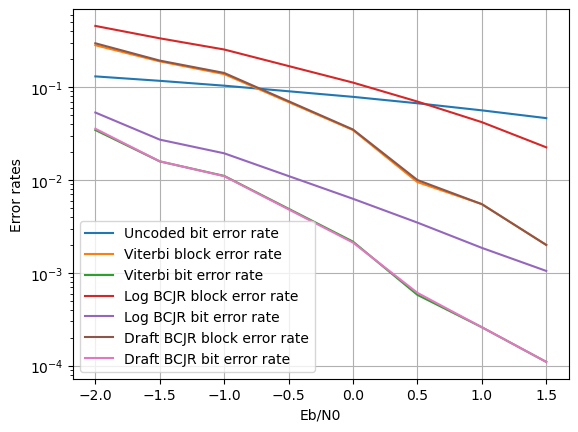

In [87]:
from scipy import special
def Q(x):
  return 0.5 - 0.5*special.erf(x/np.sqrt(2))

ebn0 = e[:,0]
sigma = np.power(10,-ebn0/20)/np.sqrt(2)
uncoded_rate = [Q(1/x) for x in sigma]
plt.semilogy(ebn0,uncoded_rate)
plt.semilogy(ebn0,[x[1:] for x in e]) # other error rates

plt.grid()
plt.xlabel("Eb/N0")
plt.ylabel("Error rates")
plt.legend(["Uncoded bit error rate", "Viterbi block error rate", "Viterbi bit error rate", "Log BCJR block error rate", "Log BCJR bit error rate", "Draft BCJR block error rate", "Draft BCJR bit error rate"])
print("THE LOG BCJR BIT ERROR RATE CANNOT BE RIGHT!")

You should try to experiment with further simulations. For example, with minor alterations to the scenario above, you could try to investigate:
* the effect of termination on error rate
* how the number of delays/states affects error rate
* for the same number of delay/state, how do different convolutional polynomials compare? Are there better and worse ones?
* from what lengths does the weakness of the draft BCJR become apparent? For long data blocks / codewords, this multiplicative implementation will see numbers become very small and addition of small numbers is numerically tricky, so this effect should become more and more apparent with longer lengths.

##5. Looking further

If you are interested in looking beyond the scope of the short lab, you may want to explore the following:
* extending our encoder and decoder framework to recursive systematic encoders
* implementing puncturing and incorporating puncturing in the decoders
* Turbo coding / decoding
* implementations of Viterbi and the BCJR for channels with insertions and deletions (with applications to DNA alignment)

The first 3 of these topics are the subject of the FTR.
